In [14]:
from tensorflow.keras.models import load_model
from tensorflow.data import Dataset
import tensorflow as tf
import pandas as pd
import json
import cv2
import matplotlib.pyplot as plt
from pathlib import Path
import pickle
from tqdm import tqdm
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#### Loading Dataset and setup

In [15]:
# Loading the history
with open("./aptos2019_history.pkl","rb") as file:
    history = pickle.load(file)
    
# Loading Config
with open("../config.json") as file:
    config = json.load(file)
 
aptos2019_path = Path(config["dataset"]["aptos_2019"]["balanced_resized"])
models_trained_path = Path(config["models_trained"])
models_path = Path(config["models_folder"])
model_cnn_1_path = models_path / "cnn_1.keras"
model_resnet50_pretrained_1_path = models_path / "resnet50_pretrained_1.keras"

In [18]:
csv = pd.read_csv(aptos2019_path / "labels.csv")
images_path = str(aptos2019_path / "images")

num_class = 5
def name2image_class2onehot(tensor):
    # Loading and processing image
    image_name = "/" + tensor["img_name"] + ".png"
    image_path = images_path + image_name
    image_file = tf.io.read_file(image_path)
    image_file = tf.io.decode_png(image_file,channels=3)
    image_file = tf.cast(image_file,tf.float32)
    image_file = tf.image.resize(image_file,[224,224])
    image_file /= 255.0
    # onehotting the class 
    onehot_class = tf.one_hot(tensor["class"], depth = num_class)
    
    return (image_file, onehot_class)

tf.random.set_seed(342)
aptos2019_dataset = (Dataset
                     .from_tensor_slices(dict(csv))
                     .shuffle(len(csv))
                     .map(name2image_class2onehot))

# Selecting sizes of train, val and test dataset
dataset_size = dict() 
dataset_size["train"] = 0.7 
dataset_size["val"]   = 0.2
dataset_size["test"]  = 0.1

# creating train, test, val datasets
for key in dataset_size:
    dataset_size[key] = int(dataset_size[key] * len(aptos2019_dataset))
dataset = dict()
dataset["train"] = aptos2019_dataset.take(dataset_size["train"]) 
dataset["val"] = aptos2019_dataset.skip(dataset_size["train"]).take(dataset_size["val"])
dataset["test"] = aptos2019_dataset.skip(dataset_size["train"] + dataset_size["val"]).take(dataset_size["test"]) 

# batching the splits
batch_size = 8
dataset["train"] = dataset["train"].batch(batch_size)
dataset["val"] = dataset["val"].batch(batch_size)
#  dataset["test"] = dataset["test"].batch(batch_size)

print("Splitting sizes:")
for key in dataset_size:
    print(f"- {key} size : {dataset_size[key]}")

# example of a tensor from train set
print("\nExample Tensor:")
for tensor in dataset["train"].take(1):
    print("Batched Input shape:", tensor[0].shape)
    print("Batched One-hot Tensor Shape:", tensor[1].shape)
    print("One-hot Tensor numpy", tensor[1].numpy()[0])

Splitting sizes:
- train size : 12959
- val size : 3702
- test size : 1851

Example Tensor:
Batched Input shape: (8, 224, 224, 3)
Batched One-hot Tensor Shape: (8, 5)
One-hot Tensor numpy [0. 0. 0. 0. 1.]


2024-12-15 16:11:14.760606: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


#### CNN - 1
* This model is build using research paper.
* More details in train/CNN notebook 

In [4]:
model_cnn_1 = load_model(model_cnn_1_path)

model_cnn_1.compile(
    optimizer = "adam",
    loss = "categorical_crossentropy",
    metrics = ["categorical_accuracy","recall","precision"]
)

history["cnn_1"] = model_cnn_1.fit(
    dataset["train"],
    validation_data = dataset["val"],
    epochs = 50
)

Epoch 1/50


I0000 00:00:1734194657.653530    5193 service.cc:148] XLA service 0x7fc560013300 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734194657.653581    5193 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2024-12-14 16:44:17.712558: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1734194657.952454    5193 cuda_dnn.cc:529] Loaded cuDNN version 90300


   4/1620 ━━━━━━━━━━━━━━━━━━━━ 35s 22ms/step - categorical_accuracy: 0.3359 - loss: 2.3357 - precision: 0.0587 - recall: 0.0282

I0000 00:00:1734194663.314811    5193 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1620/1620 ━━━━━━━━━━━━━━━━━━━━ 48s 25ms/step - categorical_accuracy: 0.3303 - loss: 1.5387 - precision: 0.5666 - recall: 0.0968 - val_categorical_accuracy: 0.4571 - val_loss: 1.2682 - val_precision: 0.7971 - val_recall: 0.1475
Epoch 2/50
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 32s 20ms/step - categorical_accuracy: 0.4445 - loss: 1.2809 - precision: 0.6874 - recall: 0.1953 - val_categorical_accuracy: 0.5170 - val_loss: 1.1492 - val_precision: 0.7249 - val_recall: 0.2825
Epoch 3/50
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 34s 21ms/step - categorical_accuracy: 0.5002 - loss: 1.1862 - precision: 0.6954 - recall: 0.2677 - val_categorical_accuracy: 0.5475 - val_loss: 1.0985 - val_precision: 0.6951 - val_recall: 0.3855
Epoch 4/50
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 35s 22ms/step - categorical_accuracy: 0.5331 - loss: 1.1179 - precision: 0.7020 - recall: 0.3186 - val_categorical_accuracy: 0.5937 - val_loss: 0.9971 - val_precision: 0.7480 - val_recall: 0.4017
Epoch 5/50
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 34s 21ms/step - c

In [5]:
model_cnn_1.save(models_trained_path / "cnn_1.keras")

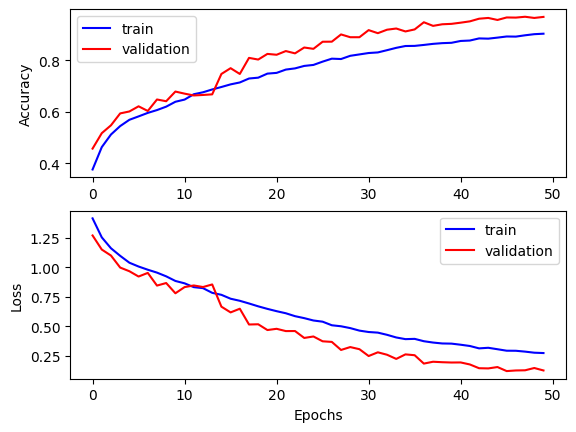

In [23]:
hmodel = "cnn_1" 

# Plotting the accuracy 
plt.subplot(2,1,1)
plt.plot(history[hmodel].epoch, history[hmodel].history["categorical_accuracy"],color="blue",label="train")
plt.plot(history[hmodel].epoch, history[hmodel].history["val_categorical_accuracy"],color="red",label="validation")
plt.ylabel("Accuracy")
plt.legend()

# plotting the loss
plt.subplot(2,1,2)
plt.plot(history[hmodel].epoch, history[hmodel].history["loss"],color="blue",label="train")
plt.plot(history[hmodel].epoch, history[hmodel].history["val_loss"],color="red",label="validation")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

plt.show()

  0%|                                                                                          | 0/1851 [00:00<?, ?it/s]/home/karthikgpu/tf_gpu/tf218/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: input_layer. Received: the structure of inputs=('*',)
  warnings.warn(
100%|███████████████████████████████████████████████████████████████████████████████| 1851/1851 [02:03<00:00, 14.99it/s]


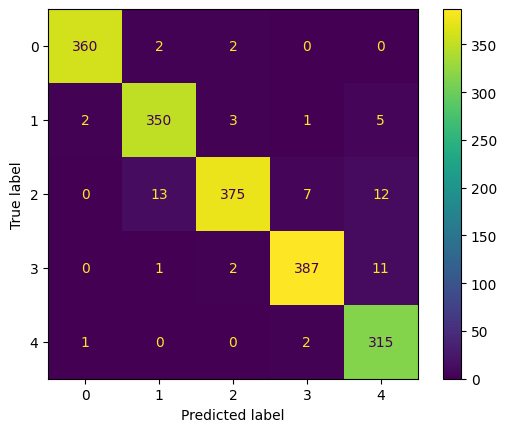

In [22]:
# Computing the confusion Matrix for cnn-1
ground_truths = []
predictions = []
for tensor in tqdm(dataset["test"]):
    image = tensor[0].numpy()
    image = np.expand_dims(image,0)
    image_class = np.argmax(tensor[1].numpy())
    current_prediction = np.argmax(model_cnn_1.predict([image],verbose=0))
    ground_truths.append(image_class)
    predictions.append(current_prediction)
conf_matrix = confusion_matrix(ground_truths,predictions)

# Plot the confusion matrix
conf_fig = ConfusionMatrixDisplay(conf_matrix)
conf_fig.plot()

#### Pretrained Resnet50 - 1
* Built-in tensorflow model with imagenet weights.
* Average Pooling -> Dense(512) -> Dense(5,"softmax")

In [20]:
model_resnet50_pretrained_1 = load_model(model_resnet50_pretrained_1_path)

model_resnet50_pretrained_1.compile(
    optimizer = "adam",
    loss = "categorical_crossentropy",
    metrics = ["categorical_accuracy","recall","precision"]
)

history["resnet50_pretrained_1"] = model_resnet50_pretrained_1.fit(
    dataset["train"],
    validation_data = dataset["val"],
    epochs = 10
)

Epoch 1/10


I0000 00:00:1734279249.313794    1056 service.cc:148] XLA service 0x7fdbac002810 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734279249.315408    1056 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2024-12-15 16:14:10.338531: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1734279254.280701    1056 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-12-15 16:14:16.261946: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_15506_0', 8 bytes spill stores, 8 bytes spill loads

I0000 00:00:1734279284.198227    1056 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1619/1620 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - categorical_accuracy: 0.3303 - loss: 1.5347 - precision: 0.6095 - recall: 0.0843

2024-12-15 16:18:16.186980: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_15506_0', 8 bytes spill stores, 8 bytes spill loads



1620/1620 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - categorical_accuracy: 0.3304 - loss: 1.5346 - precision: 0.6095 - recall: 0.0843

2024-12-15 16:19:11.755538: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1733_0', 8 bytes spill stores, 8 bytes spill loads



1620/1620 ━━━━━━━━━━━━━━━━━━━━ 334s 168ms/step - categorical_accuracy: 0.3304 - loss: 1.5345 - precision: 0.6096 - recall: 0.0843 - val_categorical_accuracy: 0.3085 - val_loss: 1.6314 - val_precision: 0.3935 - val_recall: 0.0748
Epoch 2/10
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 235s 145ms/step - categorical_accuracy: 0.3938 - loss: 1.3555 - precision: 0.7776 - recall: 0.1380 - val_categorical_accuracy: 0.4757 - val_loss: 1.2021 - val_precision: 0.7678 - val_recall: 0.1921
Epoch 3/10
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 253s 156ms/step - categorical_accuracy: 0.4912 - loss: 1.1799 - precision: 0.7166 - recall: 0.2498 - val_categorical_accuracy: 0.4254 - val_loss: 1.4802 - val_precision: 0.4951 - val_recall: 0.3379
Epoch 4/10
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 240s 148ms/step - categorical_accuracy: 0.5383 - loss: 1.0772 - precision: 0.7063 - recall: 0.3201 - val_categorical_accuracy: 0.4476 - val_loss: 1.7019 - val_precision: 0.5007 - val_recall: 0.3720
Epoch 5/10
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 237s 146m

In [21]:
model_resnet50_pretrained_1.save(models_trained_path / "resnet50_pretrained_1.keras")

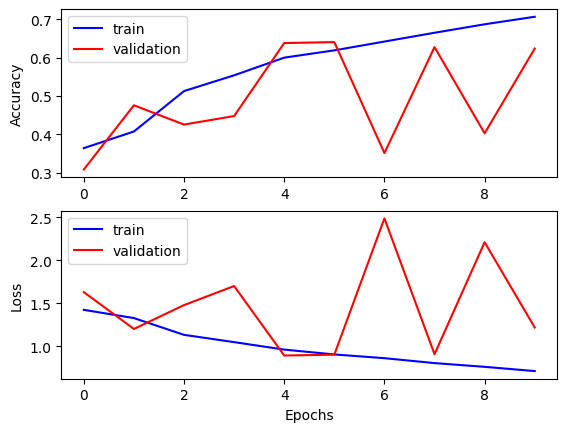

In [22]:
hmodel = "resnet50_pretrained_1" 

# Plotting the accuracy 
plt.subplot(2,1,1)
plt.plot(history[hmodel].epoch, history[hmodel].history["categorical_accuracy"],color="blue",label="train")
plt.plot(history[hmodel].epoch, history[hmodel].history["val_categorical_accuracy"],color="red",label="validation")
plt.ylabel("Accuracy")
plt.legend()

# plotting the loss
plt.subplot(2,1,2)
plt.plot(history[hmodel].epoch, history[hmodel].history["loss"],color="blue",label="train")
plt.plot(history[hmodel].epoch, history[hmodel].history["val_loss"],color="red",label="validation")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

plt.show()

  0%|                                                                                          | 0/1851 [00:00<?, ?it/s]/home/karthikgpu/tf_gpu/tf218/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: input_layer_4. Received: the structure of inputs=('*',)
  warnings.warn(
100%|███████████████████████████████████████████████████████████████████████████████| 1851/1851 [02:33<00:00, 12.06it/s]


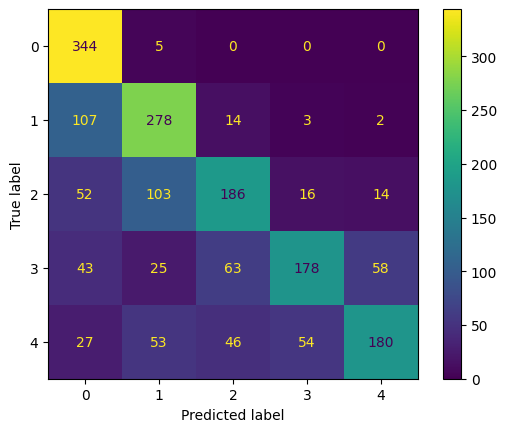

In [27]:
# Computing the confusion Matrix for cnn-1
ground_truths = []
predictions = []
for tensor in tqdm(dataset["test"]):
    image = tensor[0].numpy()
    image = np.expand_dims(image,0)
    image_class = np.argmax(tensor[1].numpy())
    current_prediction = np.argmax(model_resnet50_pretrained_1.predict([image],verbose=0))
    ground_truths.append(image_class)
    predictions.append(current_prediction)
conf_matrix = confusion_matrix(ground_truths,predictions)

# Plot the confusion matrix
conf_fig = ConfusionMatrixDisplay(conf_matrix)
conf_fig.plot()

In [25]:
# Saving the history
with open("./aptos2019_history.pkl","wb") as file:
    pickle.dump(history,file)